In [1]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../')
sys.path.insert(1,'../lib/')

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')


# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo
from torch.autograd import Variable



# Numpy, Matplotlib, Pandas, Sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from sklearn import manifold
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
from PIL import Image, ImageStat
from matplotlib.pyplot import imshow
%matplotlib inline


# python utilities
from itertools import combinations
import pickle
from tqdm import tqdm_notebook as tqdm
import copy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx
import os
from IPython.display import Image
from IPython.core.debugger import set_trace
import collections
from functools import partial
import math
import time
import glob



# Extra imports
from lib.feature_extractor import FeatureExtractor
from lib.custom_dataset import Contour_Dataset
from lib.build_fe_ft_models import *
from lib.misc_functions import imshow_grid
from lib.field_stim_functions import *
from lib import receptive_fields


updated june4


# Setup folders if we are saving some files

In [2]:
if(not os.path.exists('../saved_model/')):
    os.makedirs('../saved_model/')
    

# Hyperparameters

### Extract all the values from the config variables

In [3]:
from visualdiet_basemodel_config import *

print('\n Visual Diet config \n')
print(visual_diet_config)


print('\n Base Model Config \n')
print(training_config)


 Visual Diet config 

{'root_directory': '/home/jovyan/work/Datasets/contour_integration/model-training/config_0/', 'get_B': [0, 15, 30, 45, 60, 75], 'get_D': [32], 'get_A': [0], 'get_numElements': [12]}

 Base Model Config 

{'fine_tune': True, 'base_model_name': 'alexnet-bagnet33_regim_categ', 'layer_name': 'features.9', 'batch_size': 8, 'num_workers': 32, 'use_device': '2', 'total_num_epochs': 100, 'optimizer_name': 'sgd', 'optimizer_lr': 0.0001, 'optimizer_momentum': 0.9, 'optimizer_wd': 0.0, 'is_scheduler': True}


In [4]:
root_directory=visual_diet_config['root_directory']
get_B=visual_diet_config['get_B']
get_D=visual_diet_config['get_D']
get_A=visual_diet_config['get_A']
get_numElements=visual_diet_config['get_numElements']





batch_size=training_config['batch_size']
num_workers=training_config['num_workers']
if(training_config['use_device']=='cpu'):
    device='cpu'
else:
    if torch.cuda.is_available():
        device = torch.device('cuda:'+training_config['use_device'])
    else:
        device='cpu'


fine_tune=training_config['fine_tune']
mode='finetune' if training_config['fine_tune'] else 'frozen'
base_model_name=training_config['base_model_name']
layer_name=training_config['layer_name']
num_workers=training_config['num_workers']


if('vit' not in training_config['base_model_name']):
    temp_input_to_base=torch.randn(2,3,512,512)
    img_dim=512
else:
    temp_input_to_base=torch.randn(2,3,384,384)
    img_dim=384

### Data Transforms

In [5]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

# Dataset and Dataloaders

In [6]:
train_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=True,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements,total_images=5000)
train_loader_norm = torch.utils.data.DataLoader(dataset=train_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=True)

train_dataset_without_norm = Contour_Dataset(root=root_directory,transform=data_transform_without_norm,train=True,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements,total_images=5000)
train_loader_without_norm = torch.utils.data.DataLoader(dataset=train_dataset_without_norm, batch_size=batch_size, num_workers=num_workers, shuffle=True)


In [7]:
# Data splits across teh condition
train_dataset_norm.condition_frequency('c')
print('\n')
train_dataset_norm.condition_frequency('D')
print('\n')
train_dataset_norm.condition_frequency('B')
print('\n')
train_dataset_norm.condition_frequency('A')
print('\n')
train_dataset_norm.condition_frequency('numElements')




TOTAL Datapoints:  4992
Condition/Factor  c :	 control 	 2496
Condition/Factor  c :	 contour 	 2496


TOTAL Datapoints:  4992
Condition/Factor  D :	 32.0 	 4992


TOTAL Datapoints:  4992
Condition/Factor  B :	 0 	 832
Condition/Factor  B :	 75 	 832
Condition/Factor  B :	 45 	 832
Condition/Factor  B :	 15 	 832
Condition/Factor  B :	 60 	 832
Condition/Factor  B :	 30 	 832


TOTAL Datapoints:  4992
Condition/Factor  A :	 0 	 4992


TOTAL Datapoints:  4992
Condition/Factor  numElements :	 12 	 4992


In [8]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset_without_norm = Contour_Dataset(root=root_directory,transform=data_transform_without_norm,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_without_norm = torch.utils.data.DataLoader(dataset=val_dataset_without_norm, batch_size=batch_size, num_workers=num_workers, shuffle=True)




In [9]:
# Data splits across teh condition
val_dataset_norm.condition_frequency('c')
print('\n')
val_dataset_norm.condition_frequency('D')
print('\n')
val_dataset_norm.condition_frequency('B')
print('\n')
val_dataset_norm.condition_frequency('A')
print('\n')
val_dataset_norm.condition_frequency('numElements')



TOTAL Datapoints:  600
Condition/Factor  c :	 control 	 300
Condition/Factor  c :	 contour 	 300


TOTAL Datapoints:  600
Condition/Factor  D :	 32.0 	 600


TOTAL Datapoints:  600
Condition/Factor  B :	 0 	 100
Condition/Factor  B :	 75 	 100
Condition/Factor  B :	 45 	 100
Condition/Factor  B :	 15 	 100
Condition/Factor  B :	 60 	 100
Condition/Factor  B :	 30 	 100


TOTAL Datapoints:  600
Condition/Factor  A :	 0 	 600


TOTAL Datapoints:  600
Condition/Factor  numElements :	 12 	 600


### Train and Validation Dataloaders

In [10]:
training_config['len_train_dataset']=len(train_dataset_norm)
training_config['len_val_dataset']=len(val_dataset_norm)


dataloaders_dict={'train':train_loader_norm,'val':val_loader_norm}

# Visualizing dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 512, 512])


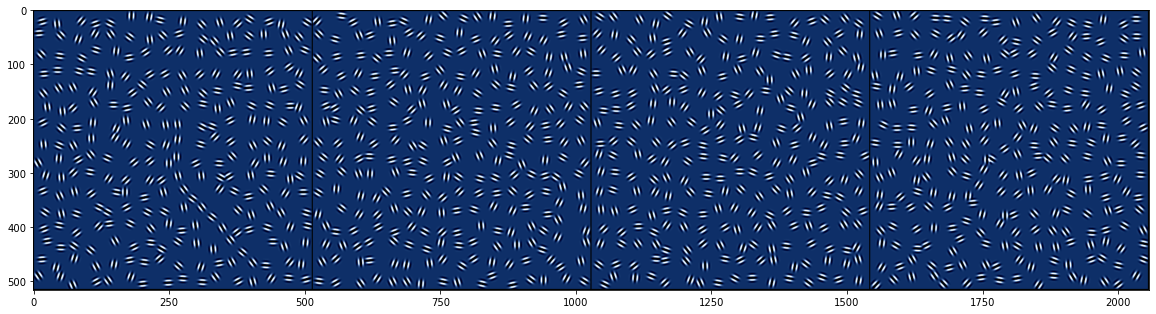

In [11]:
inputs, b, d, a, nel, labels, record =next(iter(train_loader_norm))
print(inputs.shape)
imshow_grid(torchvision.utils.make_grid(inputs[:4]),figsize=(20,20))

torch.Size([8, 3, 512, 512])


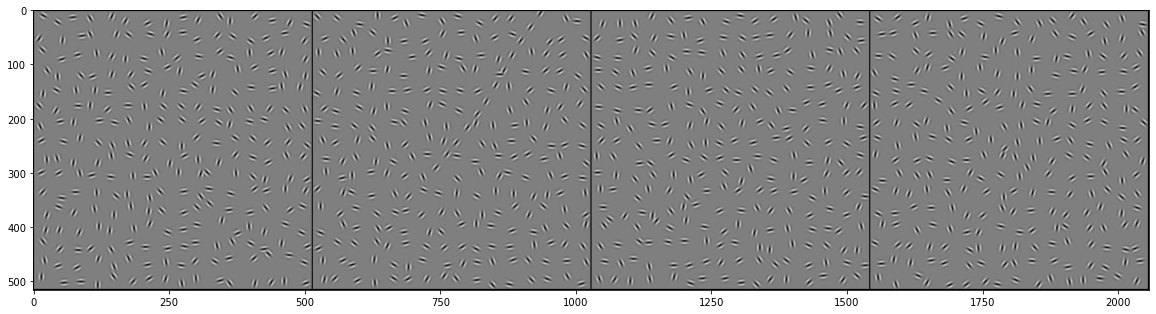

In [12]:
inputs, b, d, a, nel, labels, record =next(iter(train_loader_without_norm))
print(inputs.shape)
imshow_grid(torchvision.utils.make_grid(inputs[:4]),figsize=(20,20))

# Spliced Model -> Base model + Readout model

In [13]:
spliced_model=SpliceModel(base_model_name,layer_name,fine_tune=fine_tune,device=device)

... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dnn_contour_integration/model_weights/base_model_weights/alexnet_bagnet33_137331_final_weights_pytorch2-3b5d8dae71.pth


In [14]:
spliced_model

SpliceModel(
  (base_model): AlexNetBagnet33_137331(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(13, 13), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 192, kernel_size=(7, 7), stride=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (9): ReLU(inplace=True)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=4096, out_features=4096, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
  )
  (readout_model)

In [15]:
# from lib import receptive_fields
receptive_field_dict = receptive_fields.receptive_field_analytic(copy.deepcopy(spliced_model.base_model), (3, 512, 512))

------------------------------------------------------------------------------
             Layer (type)     map size       start        jump receptive_field 
  0. input                   [512, 512]        0.5        1.0             1.0 
  1. features.0              [250, 250]        6.5        2.0            13.0 
  2. features.1              [250, 250]        6.5        2.0            13.0 
  3. features.2              [244, 244]       12.5        2.0            25.0 
  4. features.3              [244, 244]       12.5        2.0            25.0 
  5. features.4              [242, 242]       14.5        2.0            29.0 
  6. features.5              [242, 242]       14.5        2.0            29.0 
  7. features.6              [240, 240]       16.5        2.0            33.0 
  8. features.7              [240, 240]       16.5        2.0            33.0 
  9. features.8              [240, 240]       16.5        2.0            33.0 
  10. features.9             [240, 240]       16.5 

# Optimizer, Criterion and Scheduler

In [16]:
# params_to_update = []
# for name,param in readout_model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
params_to_update=list(spliced_model.parameters())


optimizer=optim.SGD(params_to_update, lr=training_config['optimizer_lr'], momentum=training_config['optimizer_momentum'], weight_decay=training_config['optimizer_wd'])

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
if(training_config['is_scheduler']):
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=training_config['optimizer_lr'],pct_start=0.4, steps_per_epoch=len(dataloaders_dict['train']), epochs=training_config['total_num_epochs'], div_factor=100)
else:
    scheduler=None

# Training Loop

In [19]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25,save_model_weights=False):

    since = time.time()  
    

    ## Recording accuracy
    val_acc_history = []
    train_acc_history=[]
    
    ## Recording Loss
    val_loss_history=[]
    train_loss_history=[]
    
    ## Recording optimizer learning rate
    optimizer_lr=[]
    
    
    for epoch in tqdm(range(num_epochs)):


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # model.train()   # Set model to train mode
                change_train_eval_mode(model,model.fine_tune,train_eval_mode='train')
            else:
                # model.eval()   # Set model to evaluate mode
                change_train_eval_mode(model,model.fine_tune,train_eval_mode='eval')

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, b, d, a, nel, labels, record in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs= model.forward(inputs)


                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if(scheduler):
                            scheduler.step()
                            optimizer_lr.append(optimizer.param_groups[0]['lr'])

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                


            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
                # print(val_acc_history[-1])
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss)


    time_elapsed = time.time() - since
    # Save the model checkpoints
    if(save_model_weights):
        torch.save({
                'visual_diet_config':visual_diet_config,
                'training_config':training_config,
                'model_state_dict': get_modified_state_dict(spliced_model,get_untrainable_params(spliced_model)),
                'metrics':{'training_time':time_elapsed,'train_acc':train_acc_history,'train_loss':train_loss_history,'val_acc':val_acc_history,'val_loss':val_loss_history,'optim_lr':optimizer_lr},
                }, '../saved_model/model_' + training_config['base_model_name'].replace('_','-') + '_layer_' + training_config['layer_name'].replace('.','-')+'_mode_'+mode+'.pt')
    
    
    return train_acc_history, val_acc_history, train_loss_history, val_loss_history,optimizer_lr

# Start the training

In [ ]:
train_acc_history, val_acc_history, train_loss_history, val_loss_history,optimizer_lr=train_model(spliced_model, dataloaders_dict, criterion, optimizer, scheduler=scheduler, num_epochs=training_config['total_num_epochs'], save_model_weights=True)



  0%|          | 0/100 [00:00<?, ?it/s]

# Diagnostic 1: Plot accuracy and loss after finishing training

In [1]:
plt.figure(figsize=(24,8))


plt.subplot(1,2,1)
plt.plot(np.arange(len(train_acc_history)),train_acc_history,label='train')
plt.plot(np.arange(len(val_acc_history)),val_acc_history,label='val')
plt.axhline(y=0.5,linestyle='--',color='r',label='chance')

plt.xlabel('Epochs',fontsize=15,labelpad=15)
plt.ylabel('Accuracy',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   
plt.ylim(0.4,1.01)





plt.subplot(1,2,2)
plt.plot(np.arange(len(train_loss_history)),train_loss_history,label='train')
plt.plot(np.arange(len(val_loss_history)),val_loss_history,label='val')

plt.xlabel('Epochs',fontsize=15,labelpad=15)
plt.ylabel('Loss',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   


    
    
    
    
    
plt.legend()

NameError: name 'plt' is not defined

# Diagnostic 2: Plot Learrning Rate

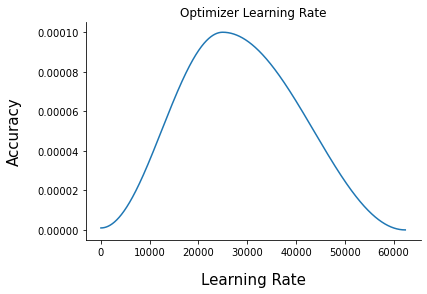

In [47]:
plt.plot(np.arange(len(optimizer_lr)),optimizer_lr)


plt.xlabel('Learning Rate',fontsize=15,labelpad=15)
plt.ylabel('Accuracy',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Optimizer Learning Rate')

plt.show()

# Diagnostic 3: Plot Weights in first layer

In [62]:
def normalize_weights(weights):
    # Normalize to [0, 1]
    min_val = weights.min()
    max_val = weights.max()
    weights = (weights - min_val) / (max_val - min_val)
    return weights

In [2]:
first_layer_weights = spliced_model.base_model.features[0].weight.data.cpu().numpy()
print(first_layer_weights.shape)
normalized_weights = normalize_weights(first_layer_weights)

# Assuming your filters are square in shape and grayscale
num_filters = normalized_weights.shape[0]
filter_size = normalized_weights.shape[2]  # Assuming (num_filters, num_channels, width, height)

first_layer_weights = spliced_model.base_model.features[0].weight.data.cpu()
normalized_weights = normalize_weights(first_layer_weights)
imshow_grid(torchvision.utils.make_grid(normalized_weights),figsize=(8,8))
plt.axis('off')

NameError: name 'spliced_model' is not defined